## Homestays Data analysis and price prediction

 ## Data Preparation

In [88]:
pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [89]:
import pandas as pd
import io

try:
    data = pd.read_excel("Homestays_Data.xlsx")
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")
    with open("Homestays_Data.xlsx", 'r', encoding='latin1') as file:
        lines = file.readlines()
    for i, line in enumerate(lines):
        try:
            pd.read_csv(io.StringIO(line)) 
        except pd.errors.ParserError:
            print(f"Error in line {i+1}: {line}")

# Check for missing values and handle if necessary
data.dropna(inplace=True) 

# Once you've completed your analysis and cleaned the data, you can save it to a new Excel file
cleaned_file_name = "cleaned_Homestays_Data.xlsx"
data.to_excel(cleaned_file_name, index=False)
print(f"Enjoy you had Cleaned the data and saved to {cleaned_file_name}")

Enjoy you had Cleaned the data and saved to cleaned_Homestays_Data.xlsx


In [90]:
data.dtypes

id                                 int64
log_price                        float64
property_type                     object
room_type                         object
amenities                         object
accommodates                       int64
bathrooms                        float64
bed_type                          object
cancellation_policy               object
cleaning_fee                        bool
city                              object
description                       object
first_review              datetime64[ns]
host_has_profile_pic              object
host_identity_verified            object
host_response_rate               float64
host_since                datetime64[ns]
instant_bookable                  object
last_review               datetime64[ns]
latitude                         float64
longitude                        float64
name                              object
neighbourhood                     object
number_of_reviews                  int64
review_scores_ra

In [91]:
data.shape

(38496, 29)

In [92]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (data.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))


Categorical variables: 14
Integer variables: 0
Float variables: 8


## 1. Feature Engineering

In [93]:
import datetime as dt
# Calculate Host Tenure
data['host_since'] = pd.to_datetime(data['host_since'])  # Convert to datetime format
data['Host_Tenure'] = (dt.datetime.now() - data['host_since']).dt.days / 365.25  # Calculate tenure in years

# Generate Amenities Count
data['Amenities_Count'] = data['amenities'].apply(lambda x: len(x.split(',')))  # Count amenities

# Determine Days Since Last Review
data['last_review'] = pd.to_datetime(data['last_review'])  # Convert to datetime format
data['Days_Since_Last_Review'] = (dt.datetime.now() - data['last_review']).dt.days  # Calculate days since last review

# Display the updated dataset with new features
print(data.head())
print("-" * 50)


         id  log_price property_type        room_type  \
1   6304928   5.129899     Apartment  Entire home/apt   
2   7919400   4.976734     Apartment  Entire home/apt   
5  12422935   4.442651     Apartment     Private room   
7  13971273   4.787492   Condominium  Entire home/apt   
8    180792   4.787492         House     Private room   

                                           amenities  accommodates  bathrooms  \
1  {"Wireless Internet","Air conditioning",Kitche...             7        1.0   
2  {TV,"Cable TV","Wireless Internet","Air condit...             5        1.0   
5  {TV,"Wireless Internet",Heating,"Smoke detecto...             2        1.0   
7  {TV,"Cable TV","Wireless Internet","Wheelchair...             2        1.0   
8  {TV,"Cable TV","Wireless Internet","Pets live ...             2        1.0   

   bed_type cancellation_policy  cleaning_fee  ...      neighbourhood  \
1  Real Bed              strict          True  ...     Hell's Kitchen   
2  Real Bed            m

## 2. Exploratory Data Analysis (EDA) / Plottings

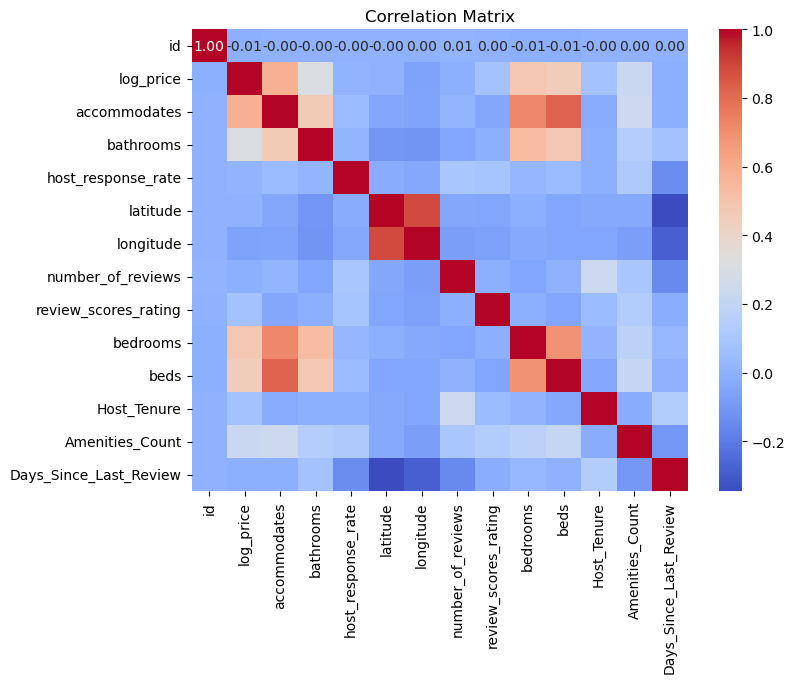

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop non-numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Correlation Matrix
corr_matrix = numeric_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


C:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


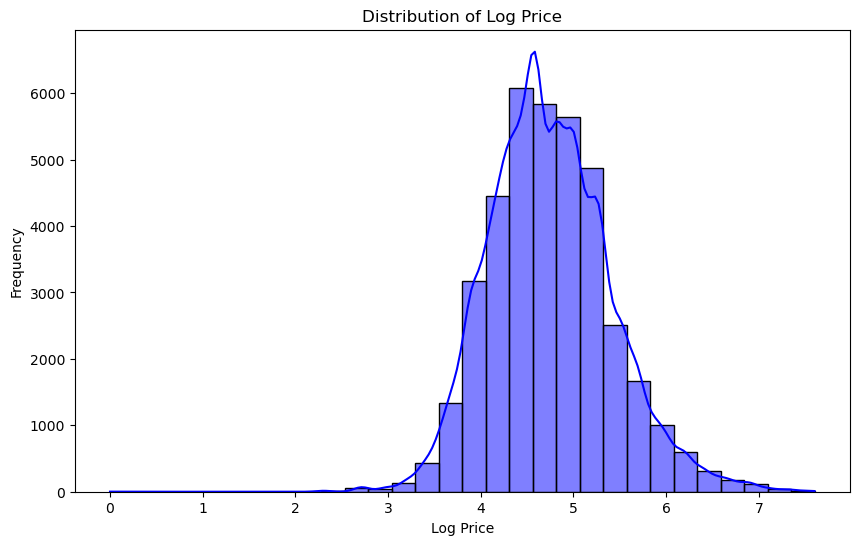

In [95]:
# Distribution Analysis
plt.figure(figsize=(10, 6))
sns.histplot(data['log_price'], bins=30, kde=True, color='blue')
plt.title('Distribution of Log Price')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

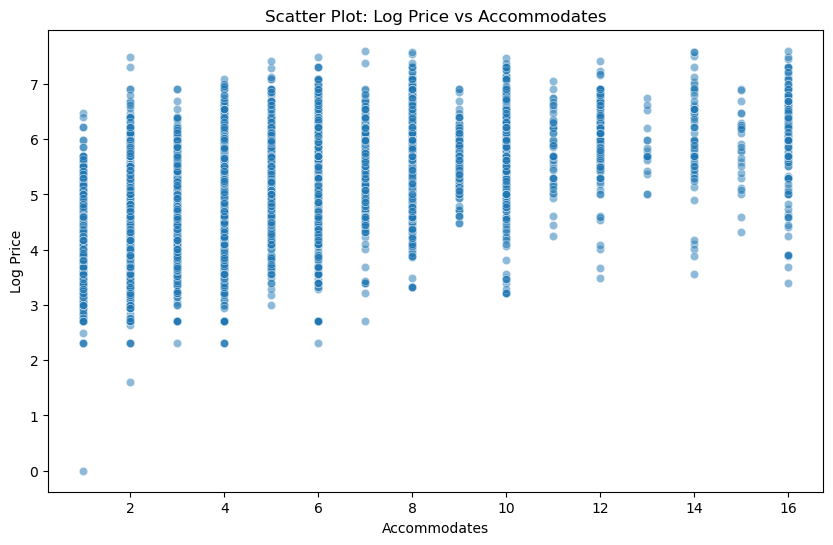

In [96]:
# Scatter plot between log_price and numerical features
plt.figure(figsize=(10, 6))
sns.scatterplot(x='accommodates', y='log_price', data=data, alpha=0.5)
plt.title('Scatter Plot: Log Price vs Accommodates')
plt.xlabel('Accommodates')
plt.ylabel('Log Price')
plt.show()

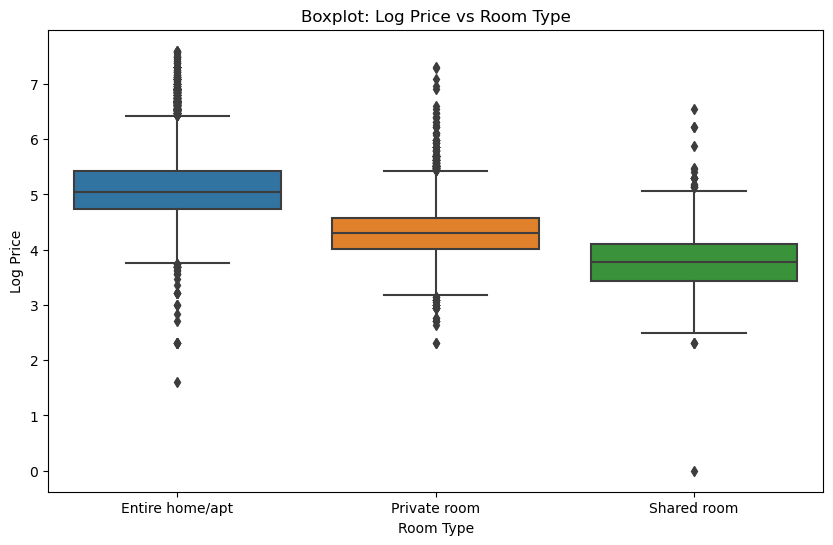

In [97]:
# Boxplot of log_price vs room_type
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='log_price', data=data)
plt.title('Boxplot: Log Price vs Room Type')
plt.xlabel('Room Type')
plt.ylabel('Log Price')
plt.show()

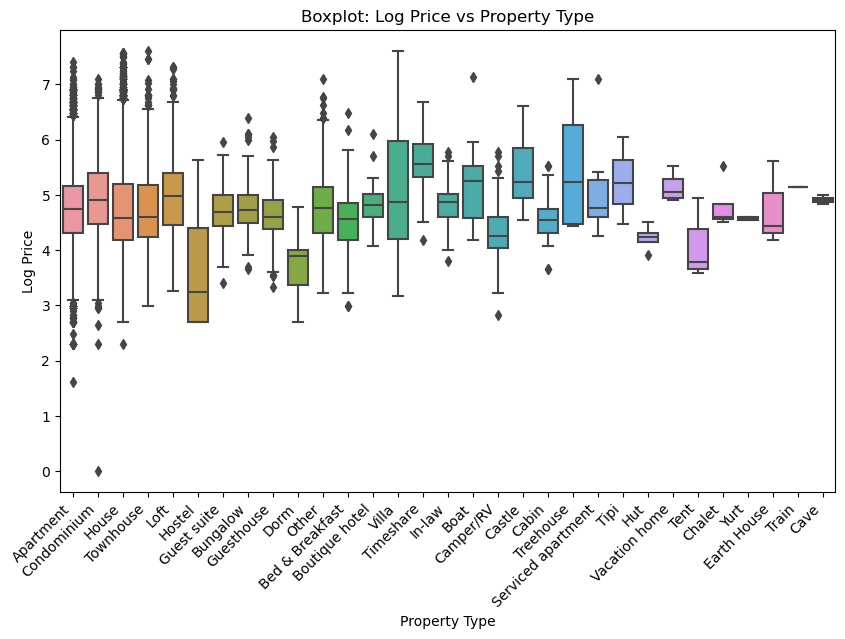

In [98]:
# Boxplot of log_price vs property_type
plt.figure(figsize=(10, 6))
sns.boxplot(x='property_type', y='log_price', data=data)
plt.title('Boxplot: Log Price vs Property Type')
plt.xlabel('Property Type')
plt.ylabel('Log Price')
plt.xticks(rotation=45, ha='right')
plt.show()

## 3. Geospatial Analysis

In [99]:
#pip install geopandas

C:\Users\nvgop\AppData\Local\Temp\ipykernel_16908\2637795176.py:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


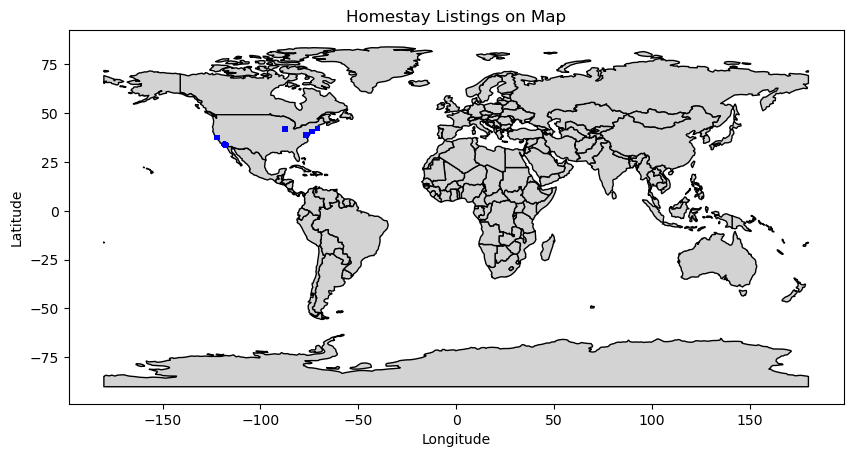

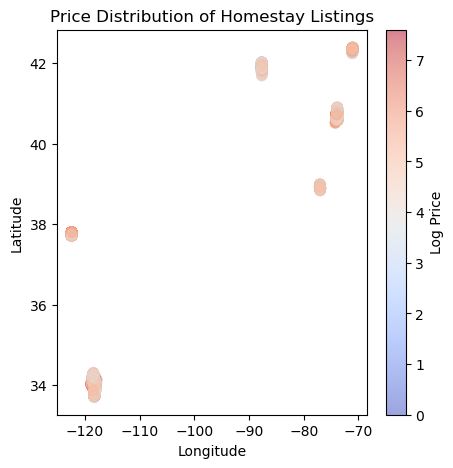

In [100]:
import geopandas as gpd
# Create a GeoDataFrame from latitude and longitude data
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))

# Plot the listings on a map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6), color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='blue', markersize=5)
plt.title('Homestay Listings on Map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [ ]:
# Visualize price distribution with color-coded markers
plt.figure(figsize=(5, 5))
plt.scatter(data['longitude'], data['latitude'], c=data['log_price'], cmap='coolwarm', s=50, alpha=0.5)
plt.colorbar(label='Log Price')
plt.title('Price Distribution of Homestay Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 4. Sentiment Analysis on Textual Data


In [101]:
from textblob import TextBlob

# Calculate sentiment scores
data['description_sentiment'] = data['description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Check the correlation between sentiment scores and log_price
sentiment_correlation = data[['description_sentiment', 'log_price']].corr()['log_price']['description_sentiment']
print("Correlation between Description Sentiment and Log Price:", sentiment_correlation)

Correlation between Description Sentiment and Log Price: 0.08252808527801363


## 5. Amenities Analysis


In [102]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Step 1: Parse Amenities
data['amenities_list'] = data['amenities'].apply(lambda x: x.replace('{', '').replace('}', '').replace('"', '').split(','))

# Step 2: Create Indicator Variables
amenities = set()
for amn_list in data['amenities_list']:
    amenities.update(amn_list)

amenities_df = pd.DataFrame(index=data.index)

for amn in amenities:
    data[amn] = data['amenities_list'].apply(lambda x: 1 if amn in x else 0)

data = pd.concat([data, amenities_df], axis=1)

# Step 3: Correlation Analysis
amenities_corr = {}
for amn in amenities:
    corr = data['log_price'].corr(data[amn])
    amenities_corr[amn] = corr

# Step 4: Statistical Tests
significant_amenities = []
for amn in amenities:
    higher_prices = data[data[amn] == 1]['log_price']
    lower_prices = data[data[amn] == 0]['log_price']
    t_stat, p_value = ttest_ind(higher_prices, lower_prices)
    if p_value < 0.05:  # significance level of 0.05
        significant_amenities.append((amn, p_value))

# Sort significant amenities by p-value
significant_amenities.sort(key=lambda x: x[1])

# Print significant amenities and their correlations
print("Top significant amenities:")
for amn, p_value in significant_amenities:
    print(f"{amn}: p-value = {p_value}, correlation = {amenities_corr[amn]}")

C:\Users\nvgop\AppData\Local\Temp\ipykernel_16908\2487014736.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[amn] = data['amenities_list'].apply(lambda x: 1 if amn in x else 0)
C:\Users\nvgop\AppData\Local\Temp\ipykernel_16908\2487014736.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[amn] = data['amenities_list'].apply(lambda x: 1 if amn in x else 0)
C:\Users\nvgop\AppData\Local\Temp\ipykernel_16908\2487014736.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `

Top significant amenities:
Family/kid friendly: p-value = 0.0, correlation = 0.30462273042964944
translation missing: en.hosting_amenity_49: p-value = 0.0, correlation = -0.24084429382003777
Cable TV: p-value = 0.0, correlation = 0.2461807365020579
TV: p-value = 0.0, correlation = 0.26477060532203534
translation missing: en.hosting_amenity_50: p-value = 0.0, correlation = -0.2229739168029601
Lock on bedroom door: p-value = 1.2747769518310832e-247, correlation = -0.17004857489828035
Hair dryer: p-value = 4.918428381965116e-218, correlation = 0.1596134594604567
Dryer: p-value = 2.2101700836792504e-216, correlation = 0.15900930707856095
Indoor fireplace: p-value = 9.95257722602797e-199, correlation = 0.15239876269227698
24-hour check-in: p-value = 4.732966821405765e-193, correlation = 0.15020813106891134
Washer: p-value = 1.3192656792091592e-192, correlation = 0.15003493171461504
Iron: p-value = 3.1904641943230994e-179, correlation = 0.1447272603260893
Laptop friendly workspace: p-value =

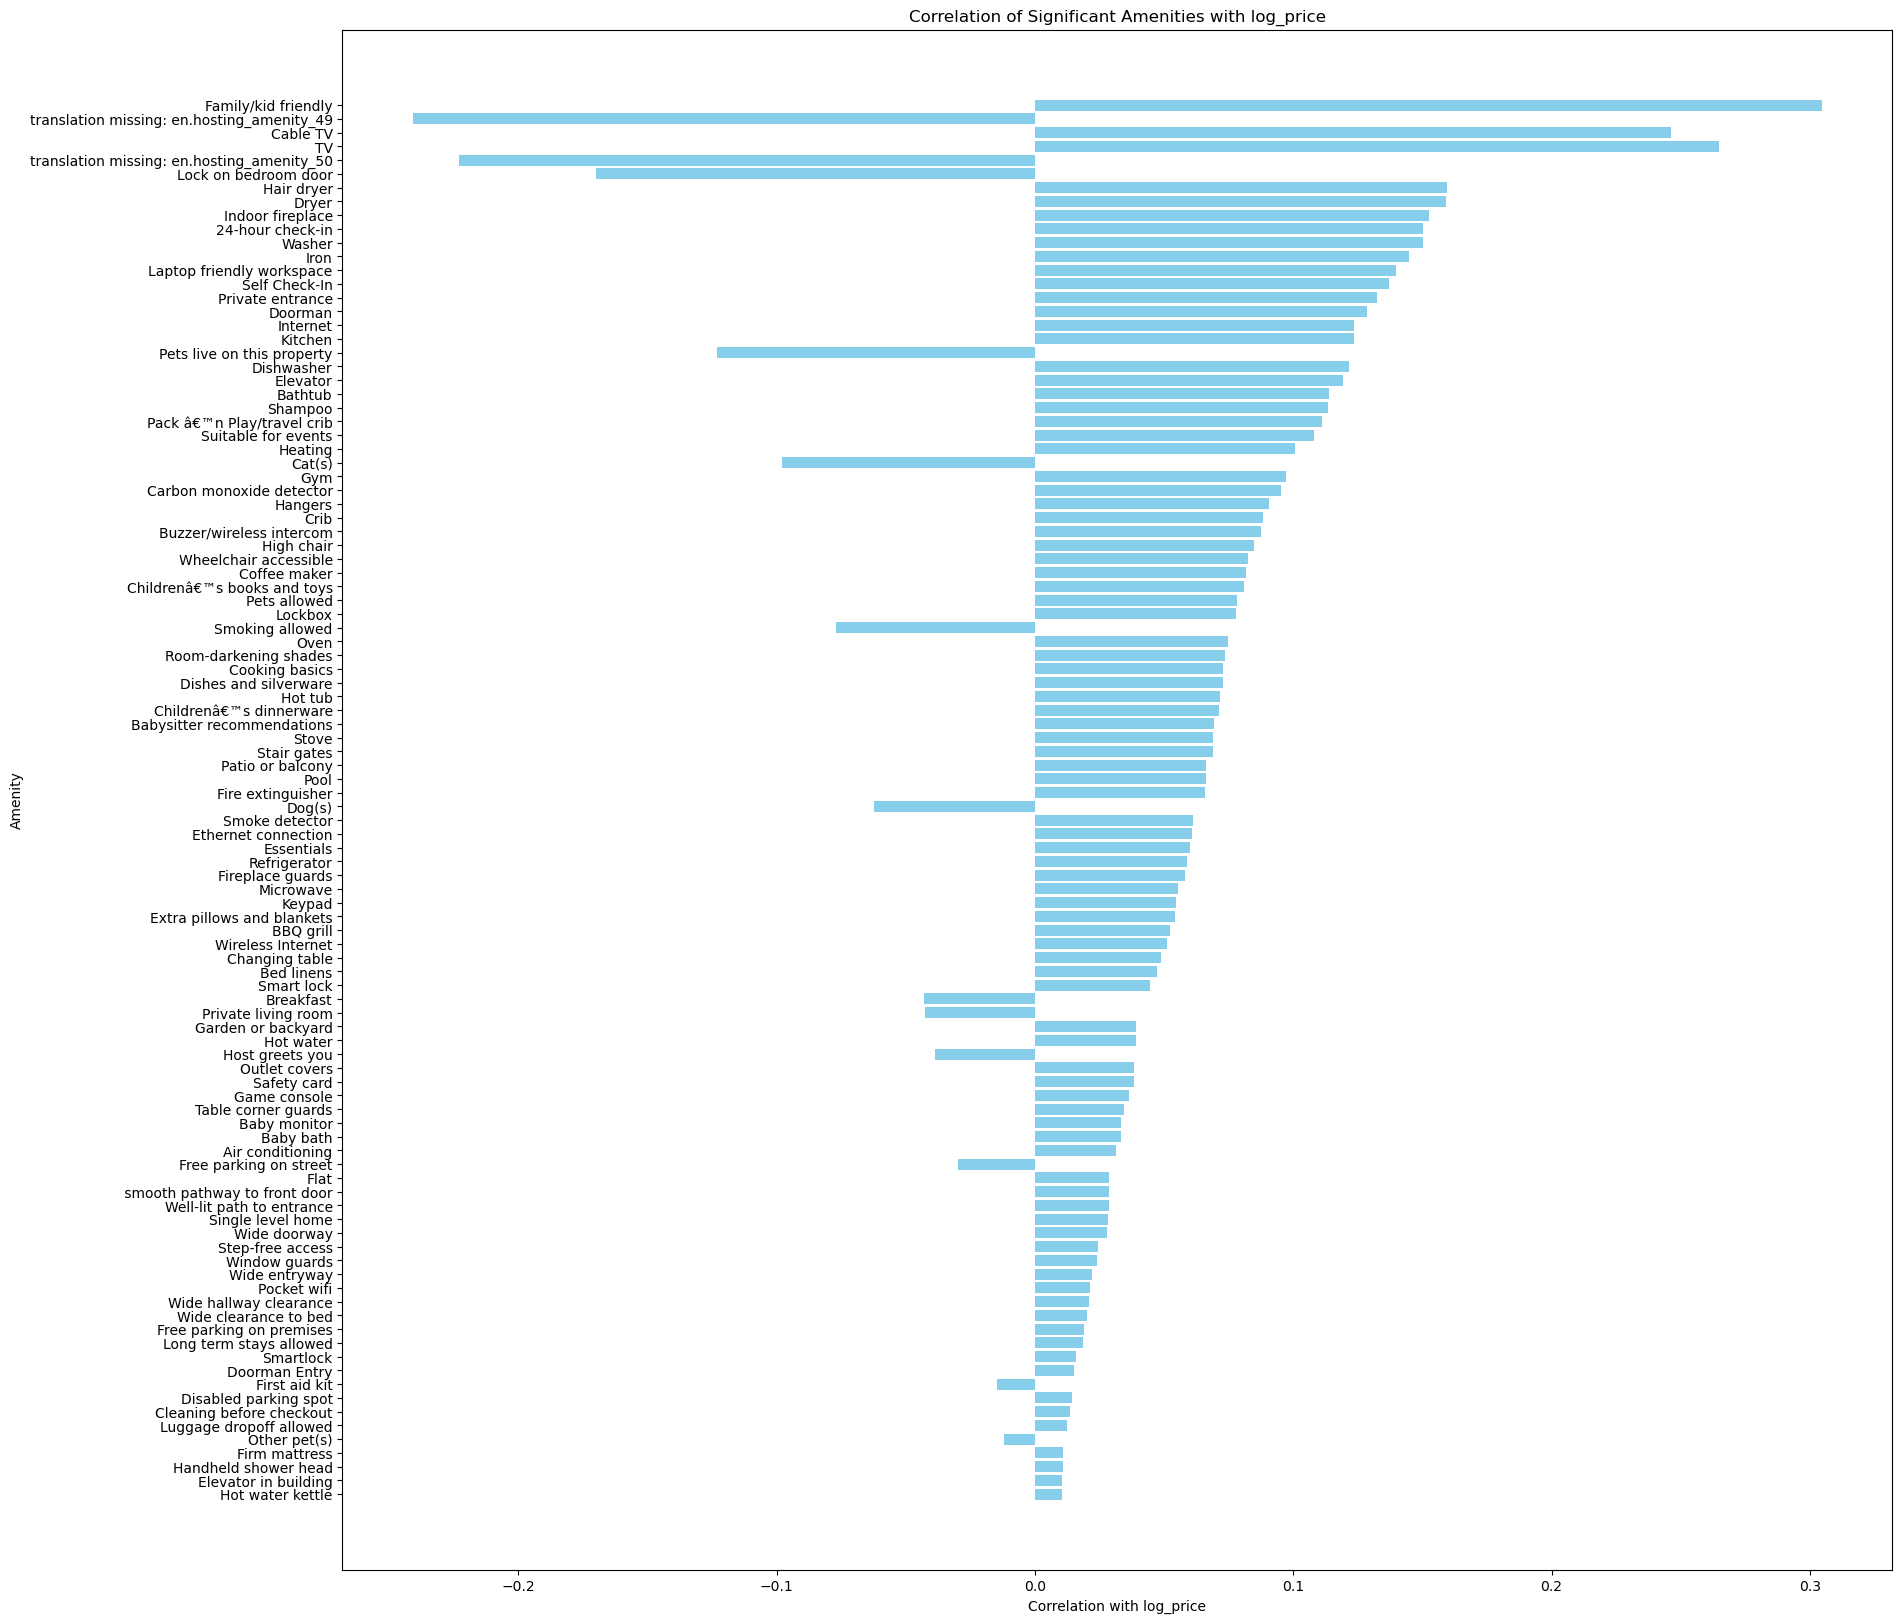

In [103]:
# Plot significant amenities and their correlations
significant_amenities_names = [amn[0] for amn in significant_amenities]
significant_amenities_correlations = [amenities_corr[amn] for amn in significant_amenities_names]

plt.figure(figsize=(20, 20))
plt.barh(significant_amenities_names, significant_amenities_correlations, color='skyblue')
plt.xlabel('Correlation with log_price')
plt.ylabel('Amenity')
plt.title('Correlation of Significant Amenities with log_price')
plt.gca().invert_yaxis()  # Invert y-axis to display amenities with higher correlations at the top
plt.show()

In [104]:
# Calculate correlation between Amenities_Count and log_price
amenities_corr = data[['Amenities_Count', 'log_price']].corr().iloc[0, 1]
print(f"Correlation between Amenities_Count and log_price: {amenities_corr}")

Correlation between Amenities_Count and log_price: 0.22754768767043054


In [105]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:")
print(object_cols)

Categorical variables:
['property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy', 'city', 'description', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'name', 'neighbourhood', 'thumbnail_url', 'zipcode', 'amenities_list']


In [106]:
print(data.columns)

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee',
       ...
       'Game console', 'Childrenâ€™s dinnerware', 'Toilet paper',
       'Elevator in building', 'Window guards', 'High chair',
       'Table corner guards', 'Flat smooth pathway to front door',
       'Firm matress', 'Laptop friendly workspace'],
      dtype='object', length=165)


## 6. Categorical Data Encoding

In [108]:
# Define categorical columns
categorical_columns = ['property_type', 'room_type', 'amenities', 'bed_type', 'cancellation_policy', 'city', 'description', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'name', 'neighbourhood', 'thumbnail_url', 'zipcode']

# Apply one-hot encoding to categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Drop columns that are not needed or suitable for modeling
columns_to_drop = ['id','amenities_list']
data_encoded = data_encoded.drop(columns=columns_to_drop, errors='ignore')

In [109]:
# Check column names
print(data_encoded.columns)

# Check number of columns
print("Number of Columns:", len(data_encoded.columns))

# Check data types
print(data_encoded.dtypes)

Index(['log_price', 'accommodates', 'bathrooms', 'cleaning_fee',
       'first_review', 'host_response_rate', 'host_since', 'last_review',
       'latitude', 'longitude',
       ...
       'zipcode_11249_x000D__x000D__x000D__x000D__x000D__x000D_\n11249',
       'zipcode_11385-2308', 'zipcode_1m', 'zipcode_20001-4044',
       'zipcode_60660-1448', 'zipcode_90036-2514', 'zipcode_90039-2715',
       'zipcode_91001-2243', 'zipcode_91606-1412',
       'zipcode_95202_x000D__x000D__x000D__x000D__x000D__x000D_\n_x000D__x000D__x000D__x000D__x000D__x000D_\n_x000D__x000D__x000D__x000D__x000D__x000D_\n94158'],
      dtype='object', length=152524)
Number of Columns: 152524
log_price                                                                                                                                                        float64
accommodates                                                                                                                                                      

## 7. Model Development and Training


Basic outline of the model-building process using linear regression as a baseline and then exploring RandomForest and GradientBoosting:

1. Data Preparation:
Split the data into training and testing sets.
Handle missing values and categorical variables appropriately (e.g., one-hot encoding).

2. Baseline Model: Linear Regression:
Fit a simple linear regression model using the training data.
Evaluate the model's performance using appropriate metrics (e.g., mean squared error, R-squared) on the testing data.

3. Explore Complex Models:
Random Forest Regression:
Train a RandomForest regression model using the training data.
Tune hyperparameters if necessary using techniques like grid search or random search.
Evaluate the model's performance on the testing data.

Gradient Boosting Regression:
Train a GradientBoosting regression model using the training data.
Tune hyperparameters if necessary.
Evaluate the model's performance on the testing data.

4. Model Evaluation:
Compare the performance of all models based on appropriate evaluation metrics.
Choose the best-performing model for further analysis.

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
data = pd.read_excel('cleaned_Homestays_Data.xlsx')
# Handle datetime columns
datetime_columns = data.select_dtypes(include=['datetime64']).columns
for col in datetime_columns:
    # Convert datetime to numeric representing days since a reference date
    data[col] = (data[col] - data[col].min()).dt.days

# Reduce cardinality of categorical variables
top_n_values = 10
for col in data.select_dtypes(include=['object']):
    top_values = data[col].value_counts().nlargest(top_n_values).index
    data[col] = data[col].where(data[col].isin(top_values), 'other')

data_encoded = pd.get_dummies(data)

X = data_encoded.drop('log_price', axis=1)
y = data_encoded['log_price']

In [117]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
# Initialize and train the model
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Make predictions
y_pred = linear_reg.predict(X_test)

# Evaluate the model
linear_reg_rmse = mean_squared_error(y_test, y_pred, squared=False)
linear_reg_r2 = r2_score(y_test, y_pred)

print("Linear Regression RMSE:", linear_reg_rmse)
print("Linear Regression R-squared:", linear_reg_r2)

Linear Regression RMSE: 0.39309347073960754
Linear Regression R-squared: 0.6492258134271318


In [119]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_reg.predict(X_test)

# Evaluate the model
rf_reg_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_reg_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest RMSE:", rf_reg_rmse)
print("Random Forest R-squared:", rf_reg_r2)


Random Forest RMSE: 0.3299389443572866
Random Forest R-squared: 0.7528827133707794


In [120]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize and train the model
gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_reg.predict(X_test)

# Evaluate the model
gb_reg_rmse = mean_squared_error(y_test, y_pred_gb, squared=False)
gb_reg_r2 = r2_score(y_test, y_pred_gb)

print("Gradient Boosting RMSE:", gb_reg_rmse)
print("Gradient Boosting R-squared:", gb_reg_r2)


Gradient Boosting RMSE: 0.3457217469840611
Gradient Boosting R-squared: 0.7286752800468732


## 8. Model Optimization and Validation

In [143]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Define parameter grids for grid search
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [4, 6]
}

gb_param_grid = {
    'learning_rate': [0.1, 0.05],
    'n_estimators': [50, 100],
    'max_depth': [4, 6]
}

# Reduce the number of folds for cross-validation
n_splits = 2

# Parallelize the grid search
n_jobs = -1

# Perform grid search with k-fold cross-validation for Random Forest
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=KFold(n_splits=n_splits), n_jobs=n_jobs)
rf_grid_search.fit(X_train, y_train)

# Perform grid search with k-fold cross-validation for Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid=gb_param_grid, cv=KFold(n_splits=n_splits), n_jobs=n_jobs)
gb_grid_search.fit(X_train, y_train)

# Get best models and parameters
best_rf_model = rf_grid_search.best_estimator_
best_gb_model = gb_grid_search.best_estimator_
best_rf_params = rf_grid_search.best_params_
best_gb_params = gb_grid_search.best_params_

print("Best Random Forest Model:", best_rf_model)
print("Best Random Forest Parameters:", best_rf_params)
print("Best Gradient Boosting Model:", best_gb_model)
print("Best Gradient Boosting Parameters:", best_gb_params)


Best Random Forest Model: RandomForestRegressor(max_depth=6, random_state=42)
Best Random Forest Parameters: {'max_depth': 6, 'n_estimators': 100}
Best Gradient Boosting Model: GradientBoostingRegressor(max_depth=6, random_state=42)
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}


## 9. Feature Importance and Model Insights

Here, we'll analyze the models to identify the most impactful features for predicting log_price.

Random Forest: Utilize feature_importances_ attribute of the trained model.
Gradient Boosting: Utilize feature importance techniques like SHAP values (external library).

In [144]:
# Get feature importances from the best Random Forest model
feature_importances_rf = best_rf_model.feature_importances_

# Create a DataFrame to display feature importances
df_feature_importances_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})
df_feature_importances_rf = df_feature_importances_rf.sort_values(by='Importance', ascending=False)
print("Random Forest Feature Importances:")
print(df_feature_importances_rf)

Random Forest Feature Importances:
                                              Feature  Importance
25                          room_type_Entire home/apt    0.608715
2                                           bathrooms    0.156929
9                                           longitude    0.097765
12                                           bedrooms    0.042632
8                                            latitude    0.031790
..                                                ...         ...
78  name_Makeçš„å°å±‹ï¼ˆåœ°ç†ä½ç½®å¥½ï¼Œäº¤é€šæ...    0.000000
79            name_SHARED ROOM in VENICE BEACH HOSTEL    0.000000
80             name_Spacious Private Room in Brooklyn    0.000000
81                      name_Your home away from home    0.000000
82                                         name_other    0.000000

[116 rows x 2 columns]


In [145]:
# Get feature importances from the best Gradient Boosting model
feature_importances_gb = best_gb_model.feature_importances_

# Create a DataFrame to display feature importances
df_feature_importances_gb = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_gb})
df_feature_importances_gb = df_feature_importances_gb.sort_values(by='Importance', ascending=False)
print("Gradient Boosting Feature Importances:")
print(df_feature_importances_gb)

Gradient Boosting Feature Importances:
                                              Feature  Importance
25                          room_type_Entire home/apt    0.481405
9                                           longitude    0.127365
2                                           bathrooms    0.112558
8                                            latitude    0.079402
1                                        accommodates    0.050922
..                                                ...         ...
66                             host_has_profile_pic_f    0.000000
65  description_æœ¬åœ°æ–¹æ˜¯ä¸ªä¸¤å±‚æ¥¼townhouseæ...    0.000000
63  description_Welcome to RMH, a co-ed hostel vib...    0.000000
94  thumbnail_url_https://a0.muscache.com/im/pictu...    0.000000
77                  name_Location, Location, Location    0.000000

[116 rows x 2 columns]


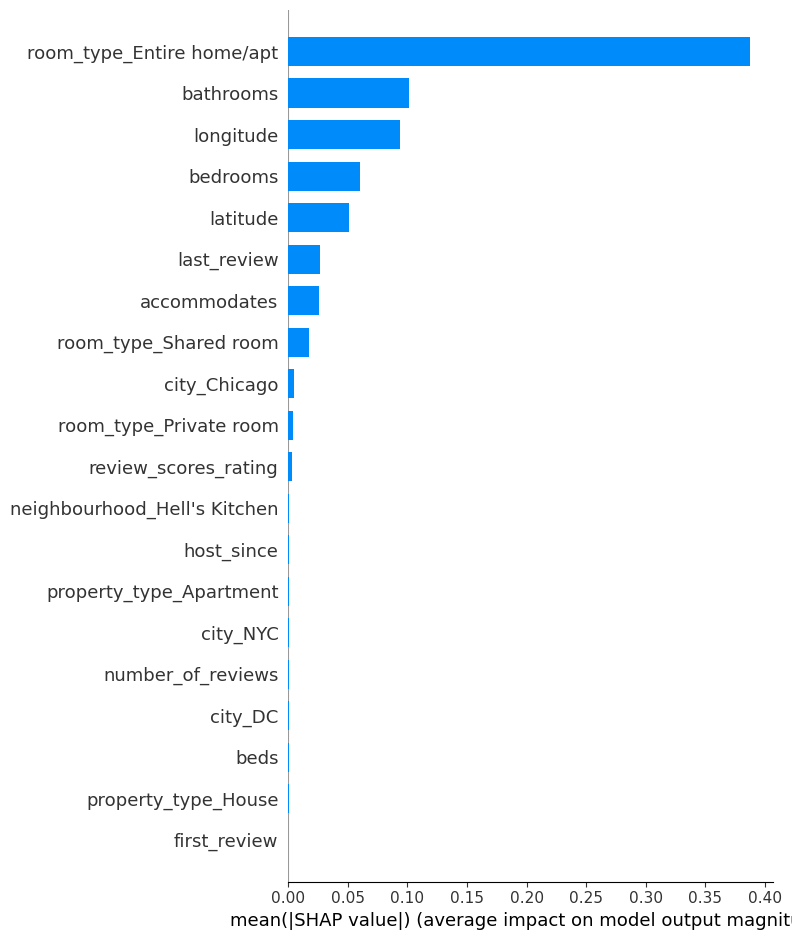

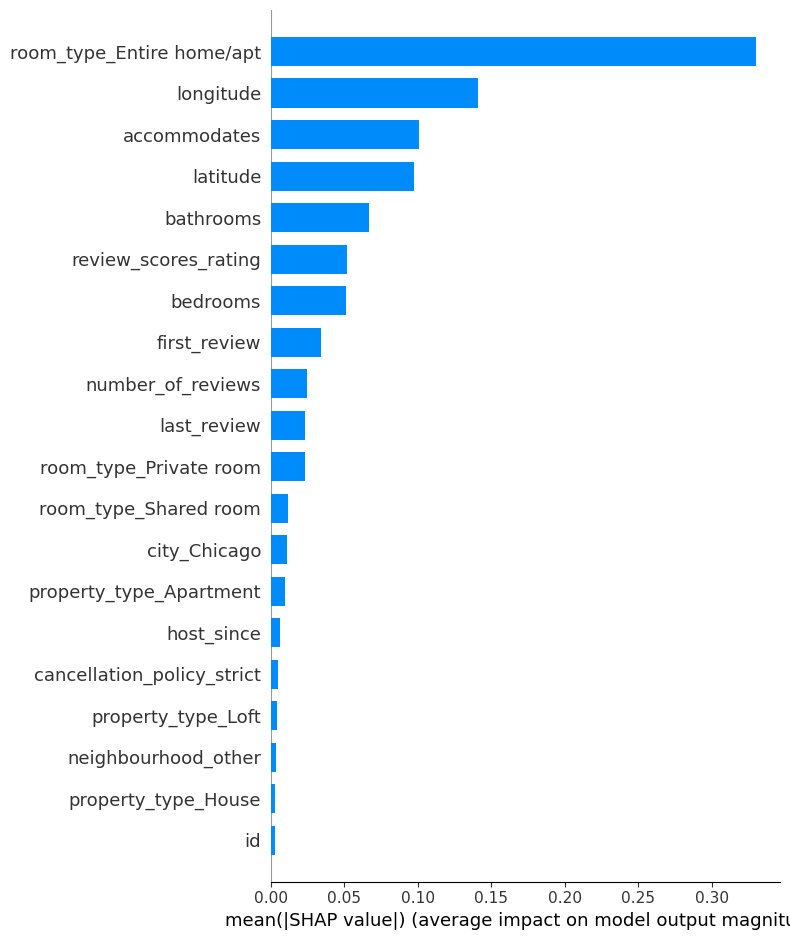

In [151]:
import shap

# Create an explainer object for the best Random Forest model
explainer_rf = shap.Explainer(best_rf_model)
shap_values_rf = explainer_rf.shap_values(X_train)

# Create an explainer object for the best Gradient Boosting model
explainer_gb = shap.Explainer(best_gb_model)
shap_values_gb = explainer_gb.shap_values(X_train)

# Plot SHAP summary plots
shap.summary_plot(shap_values_rf, X_train, plot_type='bar', title='Random Forest SHAP Values')
shap.summary_plot(shap_values_gb, X_train, plot_type='bar', title='Gradient Boosting SHAP Values')


## 10. Predictive Performance Assessment

We'll critically evaluate the final model's performance:

Reserved Test Set: Split the data further into training, validation, and testing sets. Train on the combined training and validation sets, and evaluate on the held-out testing set.
Metrics: Use RMSE, R-squared, and other relevant metrics (e.g., Mean Absolute Error) to assess accuracy and goodness-of-fit.
Residual Analysis: Plot residuals vs. predicted values to check for patterns suggesting model biases or misfit.

In [154]:
# Make predictions on the test set
y_pred_test = best_rf_model.predict(X_test)

# Calculate RMSE and R-squared
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)

print("Test Set RMSE:", test_rmse)
print("Test Set R-squared:", test_r2)

# Residual analysis
residuals = y_test - y_pred_test

Test Set RMSE: 0.3822635336621185
Test Set R-squared: 0.668287600480596


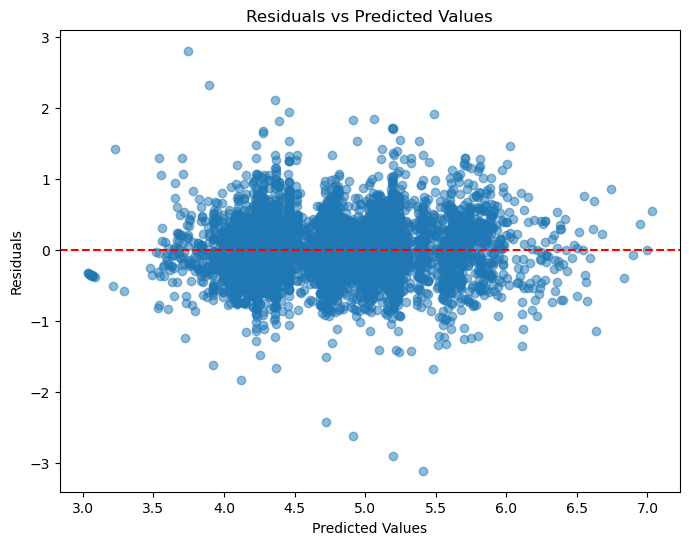

In [153]:
# Plotting residuals vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


Test Set RMSE: 0.3822635336621185
Test Set R-squared: 0.668287600480596


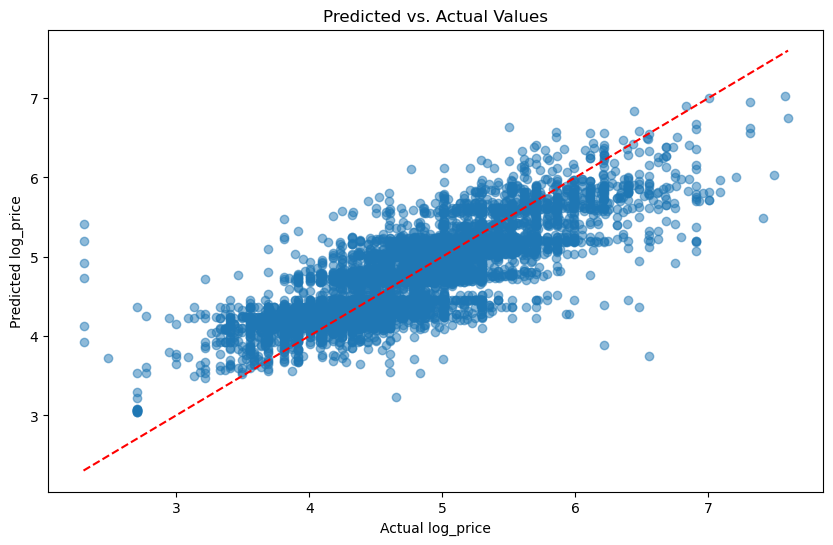

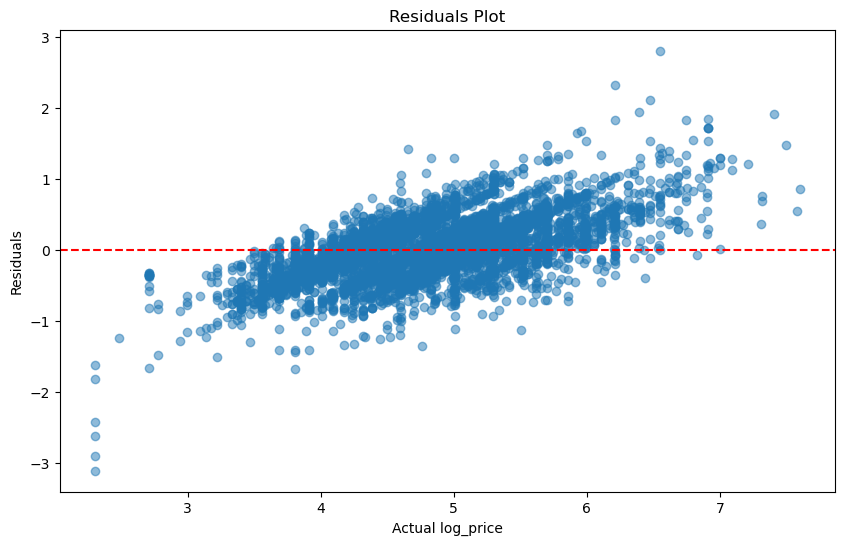

In [157]:
# Make predictions on the test set
y_pred_test = best_rf_model.predict(X_test)

# Calculate RMSE and R-squared
test_rmse = mean_squared_error(y_test, y_pred_test, squared=False)
test_r2 = r2_score(y_test, y_pred_test)

print("Test Set RMSE:", test_rmse)
print("Test Set R-squared:", test_r2)

# Residual analysis
residuals = y_test - y_pred_test

# Plot predicted values vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual log_price')
plt.ylabel('Predicted log_price')
plt.show()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Actual log_price')
plt.ylabel('Residuals')
plt.show()
